In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

In [10]:
df = pd.read_csv('sonar.all-data',header=None)

In [11]:
df.head(6)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
5,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R


In [790]:
df.shape

(208, 61)

df.info()

In [791]:
df[60].value_counts()

60
M    111
R     97
Name: count, dtype: int64

In [12]:
df[60] = df[60].map({'M': 0,'R' : 1})

In [793]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,1
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,1
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,1
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,1
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,1


In [13]:
X = df.drop(60,axis=1)
y = df[60]

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state=1)

In [15]:
X_train.shape,X_test.shape

((156, 60), (52, 60))

In [16]:
type(X_train)

pandas.core.frame.DataFrame

In [17]:
X_train_ten = torch.tensor(X_train.values,dtype=torch.float32)
y_train_ten = torch.tensor(y_train.values,dtype=torch.long)
X_test_ten = torch.tensor(X_test.values,dtype=torch.float32)
y_test_ten = torch.tensor(y_test.values,dtype=torch.long)

- PyTorch models **require tensors** (not NumPy arrays or Pandas) since tensors support autograd & GPU ops.  
- Features → `float32`, Labels → `long` (classification) or `float32` (regression).  
- Always convert data to tensors (manually or via `Dataset` + `DataLoader`).  


In [18]:
train_dataset = TensorDataset(X_train_ten,y_train_ten)
test_dataset = TensorDataset(X_test_ten,y_test_ten)

In [19]:
train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=16,shuffle=False)

# 🔹 DataLoader shuffling
- `shuffle=True` in **train_loader** → ensures batches are different every epoch, improving generalization.  
- `shuffle=False` in **test_loader** → keeps evaluation consistent/reproducible across runs.  
- Rule of thumb: **shuffle training data, don’t shuffle test/validation data**.  


### Train a Neural Network Without Dropout Regularization

In [801]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(60, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Final output layer without activation for raw logits
        )

    def forward(self, x):
        return self.network(x)

In [24]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        y_pred, y_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(y_true, y_pred)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    return train_losses, val_losses, val_accuracies 

Epoch 1/20, Train Loss: 0.6911, Val Loss: 0.6726, Val Accuracy: 0.5192
Epoch 2/20, Train Loss: 0.6812, Val Loss: 0.6662, Val Accuracy: 0.5192
Epoch 3/20, Train Loss: 0.6767, Val Loss: 0.6500, Val Accuracy: 0.5192
Epoch 4/20, Train Loss: 0.6576, Val Loss: 0.6460, Val Accuracy: 0.6346
Epoch 5/20, Train Loss: 0.6445, Val Loss: 0.6238, Val Accuracy: 0.6731
Epoch 6/20, Train Loss: 0.6092, Val Loss: 0.6067, Val Accuracy: 0.7308
Epoch 7/20, Train Loss: 0.5810, Val Loss: 0.5725, Val Accuracy: 0.6923
Epoch 8/20, Train Loss: 0.5394, Val Loss: 0.5806, Val Accuracy: 0.7500
Epoch 9/20, Train Loss: 0.5103, Val Loss: 0.5161, Val Accuracy: 0.6731
Epoch 10/20, Train Loss: 0.4535, Val Loss: 0.5644, Val Accuracy: 0.7692
Epoch 11/20, Train Loss: 0.4460, Val Loss: 0.5124, Val Accuracy: 0.7308
Epoch 12/20, Train Loss: 0.4058, Val Loss: 0.4815, Val Accuracy: 0.7308
Epoch 13/20, Train Loss: 0.3934, Val Loss: 0.4724, Val Accuracy: 0.7500
Epoch 14/20, Train Loss: 0.3933, Val Loss: 0.5741, Val Accuracy: 0.7500
E

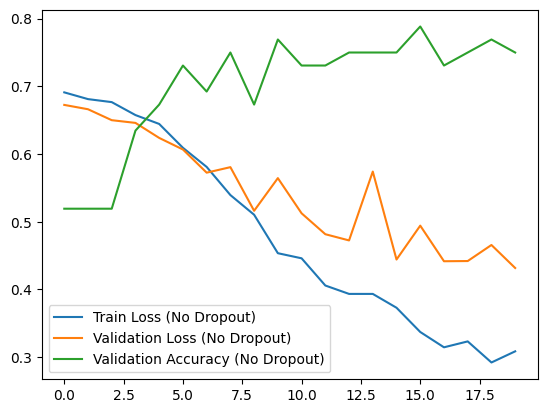

In [803]:
# Initialize and train the model without dropout
model_without_dropout = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_without_dropout.parameters(), lr=0.001)

train_losses_no_dropout, val_losses_no_dropout, val_accuracies_no_dropout = train_model(
    model_without_dropout, train_loader, test_loader, criterion, optimizer, epochs=20
)

# Plot training and validation loss and accuracy (Without Dropout)
plt.plot(train_losses_no_dropout, label="Train Loss (No Dropout)")
plt.plot(val_losses_no_dropout, label="Validation Loss (No Dropout)")
plt.plot(val_accuracies_no_dropout, label="Validation Accuracy (No Dropout)")
plt.legend()
plt.show()

In [20]:
class SimpleNN_withDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(60, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 2)  # Final output layer without activation for raw logits
        )

    def forward(self, x):
        return self.network(x)

In [22]:
# Initialize and train the model without dropout
model_with_dropout = SimpleNN_withDropout()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_dropout.parameters(), lr=0.001)

train_losses_dropout, val_losses_dropout, val_accuracies_dropout = train_model(
    model_with_dropout, train_loader, test_loader, criterion, optimizer, epochs=20
)

# Plot training and validation loss and accuracy (Without Dropout)
plt.plot(train_losses_dropout, label="Train Loss (No Dropout)")
plt.plot(val_losses_dropout, label="Validation Loss (No Dropout)")
plt.plot(val_accuracies_no_dropout, label="Validation Accuracy (No Dropout)")
plt.legend()
plt.show()

NameError: name 'train_model' is not defined